In [1]:
%pylab inline
import os
import pandas as pd
import numpy as np
import scipy.stats
RESDIR="/storage/mgymrek/ssc-denovos/denovos2/denovocalls/"
MUTEADIR="/storage/mgymrek/ssc-denovos/mutea-results/"

codis = pd.read_csv("../CODIS.bed", sep="\t", names=["chrom","pos","end","marker","mutrate"])
codis = codis[codis["mutrate"] != "?"]

# Load all denovo results
denovo = pd.read_csv(os.path.join(RESDIR,"denovos_chr1_bylength.locus_summary.tab"), sep="\t")
for chrom in range(2, 23):
    df = pd.read_csv(os.path.join(RESDIR,"denovos_chr%s_bylength.locus_summary.tab"%chrom), sep="\t")
    denovo = denovo.append(df)
codis = pd.merge(codis, denovo, on=["chrom","pos"])
codis["mutrate"] = codis["mutrate"].apply(float)

# Load mutea
mutea = pd.read_csv(os.path.join(MUTEADIR, "ssc_hipstr_mutea_codis.tab"),
                   names=["chrom","pos","end","log10mu","beta","pgeom","log10mu_se","nsamples"], sep="\t")
codis = pd.merge(mutea, codis, on=["chrom","pos"])

Populating the interactive namespace from numpy and matplotlib


In [53]:
# Adjust MUTEA to have same mean as NIST
meanlog10_CODIS = np.mean(codis["mutrate"].apply(lambda x: np.log10(x)))
meanlog10_MUTEA = np.mean(codis["log10mu"])
scale = meanlog10_CODIS/meanlog10_MUTEA
codis["log10mu_scale"] = codis["log10mu"]*scale

(0.86311580191262394, 0.0057718310411916714)

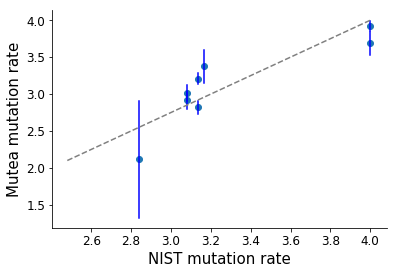

In [62]:
# Mutea CODIS estimates vs. NIST reported
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(codis["mutrate"].apply(lambda x: -1*np.log10(x)),
          codis["log10mu_scale"]*-1);
for i in range(codis.shape[0]):
    xval = codis["mutrate"].apply(lambda x: -1*np.log10(x)).values[i]
    mean = -1*codis["log10mu_scale"].values[i]
    se = codis["log10mu_se"].values[i]
    ax.plot([xval,xval],[mean-1.96*se,mean+1.96*se], color="blue")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("NIST mutation rate", size=15)
ax.set_ylabel("Mutea mutation rate", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12);
ax.plot([2.1,4.0],[2.1,4.0], linestyle="dashed", color="gray")
scipy.stats.pearsonr(codis["mutrate"].apply(lambda x: -1*np.log10(x)), codis["log10mu_scale"]*-1)

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


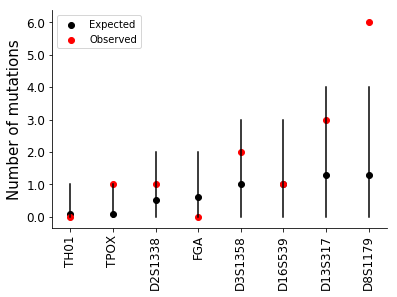

In [48]:
# Look at denovos vs. reported CODIS rate

nsim=100000
# Get expected num mutations for each marker
codis["codis_exp"] = codis.apply(lambda x: x["mutrate"]*x["total_children"], 1)
codis["codis_se"] = codis.apply(lambda x: np.sqrt(np.var(np.random.binomial(n=x["total_children"], p=x["mutrate"], size=nsim))), 1)
codis["codis_low"] = codis.apply(lambda x: np.percentile(np.random.binomial(n=x["total_children"], p=x["mutrate"], size=nsim), 2.5), 1)
codis["codis_high"] = codis.apply(lambda x: np.percentile(np.random.binomial(n=x["total_children"], p=x["mutrate"], size=nsim), 97.5), 1)
codis["pval"] = codis.apply(lambda x: np.mean([item>=x["total_mutations"] for item in np.random.binomial(n=x["total_children"], p=x["mutrate"], size=nsim)]), 1)
#codis[["chrom","pos","marker","mutrate","pval","codis_exp","codis_low","codis_high","total_children","total_mutations"]]

fig = plt.figure()
ax = fig.add_subplot(111)
codis = codis.sort("codis_exp")
codis["order"] = range(codis.shape[0])
ax.scatter(codis["order"], codis["codis_exp"], color="black", label="Expected")
for i in range(codis.shape[0]):
    x = codis["order"].values[i]
    low = codis["codis_low"].values[i]
    high = codis["codis_high"].values[i]
    obs = codis["total_mutations"].values[i]
    ax.plot([x,x],[low,high], color="black")
    if i==0: ax.scatter([x],[obs], color="red", label="Observed")
    else: ax.scatter([x],[obs], color="red")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(codis["order"])
ax.set_xticklabels(codis["marker"], rotation=90, size=12);
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.set_ylabel("Number of mutations", size=15)
ax.legend(loc="upper left")

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


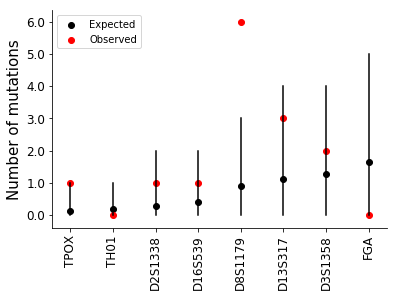

In [55]:
# Look at denovos vs. MUTEA CODIS rate

nsim=100000
# Get expected num mutations for each marker
codis["codis_exp"] = codis.apply(lambda x: 10**x["log10mu_scale"]*x["total_children"], 1)
codis["codis_se"] = codis.apply(lambda x: np.sqrt(np.var(np.random.binomial(n=x["total_children"], p=10**x["log10mu_scale"], size=nsim))), 1)
codis["codis_low"] = codis.apply(lambda x: np.percentile(np.random.binomial(n=x["total_children"], p=10**x["log10mu_scale"], size=nsim), 2.5), 1)
codis["codis_high"] = codis.apply(lambda x: np.percentile(np.random.binomial(n=x["total_children"], p=10**x["log10mu_scale"], size=nsim), 97.5), 1)
codis["pval"] = codis.apply(lambda x: np.mean([item>=x["total_mutations"] for item in np.random.binomial(n=x["total_children"], p=10**x["log10mu_scale"], size=nsim)]), 1)

fig = plt.figure()
ax = fig.add_subplot(111)
codis = codis.sort("codis_exp")
codis["order"] = range(codis.shape[0])
ax.scatter(codis["order"], codis["codis_exp"], color="black", label="Expected")
for i in range(codis.shape[0]):
    x = codis["order"].values[i]
    low = codis["codis_low"].values[i]
    high = codis["codis_high"].values[i]
    obs = codis["total_mutations"].values[i]
    ax.plot([x,x],[low,high], color="black")
    if i==0: ax.scatter([x],[obs], color="red", label="Observed")
    else: ax.scatter([x],[obs], color="red")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(codis["order"])
ax.set_xticklabels(codis["marker"], rotation=90, size=12);
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.set_ylabel("Number of mutations", size=15)
ax.legend(loc="upper left")